In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install import-ipynb
%cd /content/drive/My\ Drive/Colab\ Notebooks/RetinaSmartCamera/notebooks

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp37-none-any.whl size=2976 sha256=22b60f0178fbdda83b2375fecd065dcc365d8a38e77f6a7891d45d83d6a12406
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb
/content/drive/My Drive/Colab Notebooks/RetinaSmartCamera/notebooks


In [3]:
#Import the Retina and Dataloader notebooks
import import_ipynb
import RetinaUtils as ru

import DataLoaders

#Standard imports
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter

importing Jupyter notebook from RetinaUtils.ipynb
importing Jupyter notebook from DataLoaders.ipynb


In [ ]:
#Our Encoder module
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        #Encode a 1x8,192 retinal vector down
        #to a 1x1,448
        self.enc1 = nn.Linear(8192, 7000)
        self.enc2 = nn.Linear(6000, 4096)
        self.enc3 = nn.Linear(4096, 2896)
        self.enc4 = nn.Linear(2896, 2048)
        self.enc5 = nn.Linear(2048, 1448)
    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = F.relu(self.enc5(x))
        return x

In [ ]:
#Our Decoder module
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        #Decode a 1x1,448 vector back up to a 
        #1x8,192 retinal vector
        self.dec1 = nn.Linear(1448, 2048)
        self.dec2 = nn.Linear(2048, 2896)
        self.dec3 = nn.Linear(2896, 4096)
        self.dec4 = nn.Linear(4096, 6000)
        self.dec5 = nn.Linear(7000, 8192)
    def forward(self, x):
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.relu(self.dec5(x))
        return x 

In [ ]:
#Combine the Encoder and Decoder modules
#This was done to easily split them back up
class NeuralBottleneck(nn.Module):
    def __init__(self):
        super(NeuralBottleneck, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    def forward(self, x):
        #First encode the vector: 1x8,192->1x1,448
        x = self.encoder(x)
        #Then decode the vector: 1x1,448->1x8,192
        x = self.decoder(x)
        return x

In [ ]:
#Import the images. In this case we are using Alvaro's dataset
from DataLoaders import get_dataloader
dataloader = get_dataloader(image_type='original', personal=False skip=10, batch_size=8, shuffle=True, rgb=False)

In [5]:
#Load Ozimek's 8,192 node retina, and enable GPU acceleration
R = ru.Retina(gpu=True)
data_dir = '../retina_data/retinas/'
R.loadLoc(data_dir+'ret8k_loc.pkl')
R.loadCoeff(data_dir+'ret8k_coeff.pkl')
R.prepare((1080,1920), (540.0,960.0))

In [ ]:
#Sampling each image using Pytorch's Dataloader class is too slow,
#so this function pre-loads every retinal vector so that we only sample once
def load_img_vectors(dataloader):
    vectors = []
    j=0
    #Go over every image
    for data in iter(dataloader['train']):
        #Give update
        if j%50==0:
            print("Iteration {}".format(j))
        j += 1

        #Get images in correct shape for Ozimek's retina, and set fixation
        images, _ = data
        images = images.view(8, images.shape[1],images.shape[2])
        x = images.shape[2]/2
        y = images.shape[1]/2
        fixation = (y,x)

        #Here we store the retinal vector batches
        vector_batches = np.ones((8, 1, 8192))
        for i in range(0, 8):
            #Sample each image in a batch and save them
            V = R.sample(images[i]*255, fixation)
            vector_batches[i,:] = V/255.0
            
        vectors.append(vector_batches)
    #Return a tensor of the retinal vectors
    vectors = torch.as_tensor(vectors)
    return vectors

In [ ]:
#Load the retinal vectors
import time
start = time.time()
vectors = load_img_vectors(dataloader)
print(time.time()-start)

Iteration 0
Iteration 50
Iteration 100
Iteration 150
1027.0007064342499


In [ ]:
#Train the model
def train(model, criterion, optimiser, dataset):
    train_loss = 0
    i=0
    #iterate through the dataset
    for i, retinal_vector in enumerate(dataset):
        
        if i%100 == 0:
            print(f'Iteration {i}')
        retinal_vector = retinal_vector.float().to(device)
        
        optimiser.zero_grad()   
        outputs = model(retinal_vector)
        #Compare original retinal vector to the reconstructions.
        loss = criterion(outputs, retinal_vector)   
        loss.backward()
        optimiser.step()
        
        #Update running loss
        train_loss += loss.item()*retinal_vector.size(0)
    #Return average loss
    return train_loss/len(dataset)

def run(model, criterion, optimiser, dataloader, model_name, epochs=5):
    model.to(device)
    avg_train_loss = []
    #Train the model and save the average loss per epoch
    for epoch in range(1, epochs+1):
        print(f'----------Epoch {epoch}----------')
        train_loss = train(model, criterion, optimiser, dataloader)
        avg_train_loss.append(train_loss)
        print(f'Train loss: {train_loss}')
    
    #Plot the loss and save the figure
    plt.plot(range(1,epochs+1), avg_train_loss)
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.xticks([0,10,20,30,40,50,60,70,80,90,100])
    plt.savefig(model_name+'.eps')
    
    #Save the final model
    torch.save({
            'model_state_dict': model.state_dict(),
            }, '/content/drive/My Drive/Colab Notebooks/RetinaSmartCamera/models/'+model_name+'.pt')
    return avg_train_loss

----------Epoch 1----------
Iteration 0
Iteration 100
Train loss: 0.15624342136776326
----------Epoch 2----------
Iteration 0
Iteration 100
Train loss: 0.05731752044377253
----------Epoch 3----------
Iteration 0
Iteration 100
Train loss: 0.041290107797639274
----------Epoch 4----------
Iteration 0
Iteration 100
Train loss: 0.035853457685137535
----------Epoch 5----------
Iteration 0
Iteration 100
Train loss: 0.033737658561428185
----------Epoch 6----------
Iteration 0
Iteration 100
Train loss: 0.027280452574804884
----------Epoch 7----------
Iteration 0
Iteration 100
Train loss: 0.026744536373802683
----------Epoch 8----------
Iteration 0
Iteration 100
Train loss: 0.024012939207563082
----------Epoch 9----------
Iteration 0
Iteration 100
Train loss: 0.022208204756961347
----------Epoch 10----------
Iteration 0
Iteration 100
Train loss: 0.023196253983169487
----------Epoch 11----------
Iteration 0
Iteration 100
Train loss: 0.022682404582455906
----------Epoch 12----------
Iteration 0
It

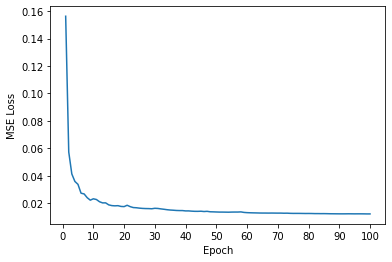

In [ ]:
#Train the neural bottleneck
start = time.time()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = NeuralBottleneck()

#MSE Loss as we are trying to compress and reconstruct the retinal vectors
criterion = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

avg_loss = run(model, criterion, optimiser, vectors, '7000_retinal_model', epochs=100)
print(f'Time taken: {time.time()-start}')